In [1]:
from wae import *
from torch.distributions import Categorical, Normal, MixtureSameFamily
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
data_path = "/n/fs/ragr-data/users/yihangs/Celegan/structuredVAE/codes/vampprior-mixture-model-test/origin/VampPrior-Mixture-Model/data/simulation/1d-gaussian/data1/"
X = np.load(data_path + "X.npy")
y = np.load(data_path + "Y.npy")
Z_true = np.load(data_path + "Z.npy")
true_centers = np.load(data_path + "centers.npy")
n_clusters = len(true_centers)

X = torch.from_numpy(X).float()

In [4]:
X.shape

torch.Size([1200, 100])

In [3]:
### define prior

mix_probs = torch.tensor([0.25, 0.25, 0.25, 0.25])

# component means and stds (K,)
means = torch.from_numpy(true_centers.reshape(-1)).float()
#means = torch.tensor([-20.0, -10.0, 0.0, 10.0])
stds  = torch.tensor([0.2, 0.2, 0.2, 0.2])

# define distributions
mix = Categorical(mix_probs)
comp = Normal(means, stds)               # batch of K Normals
gmm = MixtureSameFamily(mix, comp)

In [6]:
gmm

MixtureSameFamily(
  Categorical(probs: torch.Size([4]), logits: torch.Size([4])),
  Normal(loc: torch.Size([4]), scale: torch.Size([4])))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WAE1D(
    prior = gmm,
    in_dim=100, x_dim=100, h_dim=64,
    n_layers_enc=2, n_layers_dec=2,
    embedding_dim=1, 
).to(device)

In [5]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)

In [6]:
epochs = 1000
num_train_data = len(dl)

for ep in range(1, epochs + 1):
    print(f"epoch: {ep*1}/{epochs}")
    model.train()
    m_gather = {}
    idx = 0
    for (xb,) in dl:
        idx+=1
        xb = xb.to(device).float()

        # update 
        optimizer.zero_grad()
        loss, metrics = model(xb,weight = 10)
        loss.backward()
        optimizer.step()

        # gather metrics
        #print("temperature", temp, step)
        for k,v in metrics.items():
            m_gather[k] = m_gather.get(k, 0.) + metrics[k]

    for k,v in m_gather.items():
        m_gather[k] /= num_train_data

    print(f'train (average) : {m_gather}')

epoch: 1/1000
train (average) : {'recon_loss': tensor(253.4208, device='cuda:0'), 'wasserstein_distance': tensor(0.4990, device='cuda:0'), 'loss': tensor(258.4105, device='cuda:0')}
epoch: 2/1000
train (average) : {'recon_loss': tensor(213.5194, device='cuda:0'), 'wasserstein_distance': tensor(0.3647, device='cuda:0'), 'loss': tensor(217.1667, device='cuda:0')}
epoch: 3/1000
train (average) : {'recon_loss': tensor(135.9539, device='cuda:0'), 'wasserstein_distance': tensor(1.0319, device='cuda:0'), 'loss': tensor(146.2732, device='cuda:0')}
epoch: 4/1000
train (average) : {'recon_loss': tensor(73.8129, device='cuda:0'), 'wasserstein_distance': tensor(1.3788, device='cuda:0'), 'loss': tensor(87.6012, device='cuda:0')}
epoch: 5/1000
train (average) : {'recon_loss': tensor(46.6813, device='cuda:0'), 'wasserstein_distance': tensor(0.9047, device='cuda:0'), 'loss': tensor(55.7278, device='cuda:0')}
epoch: 6/1000
train (average) : {'recon_loss': tensor(35.2624, device='cuda:0'), 'wasserstein_

In [7]:
model.eval()
with torch.no_grad():
    latent_params = model.encoder(X.to(device))
    enc_mu = latent_params.detach().cpu().numpy()

In [25]:
latent_params

tensor([[  6.5632],
        [  7.0224],
        [  7.6973],
        ...,
        [-20.4409],
        [-19.7583],
        [-20.8652]], device='cuda:0')

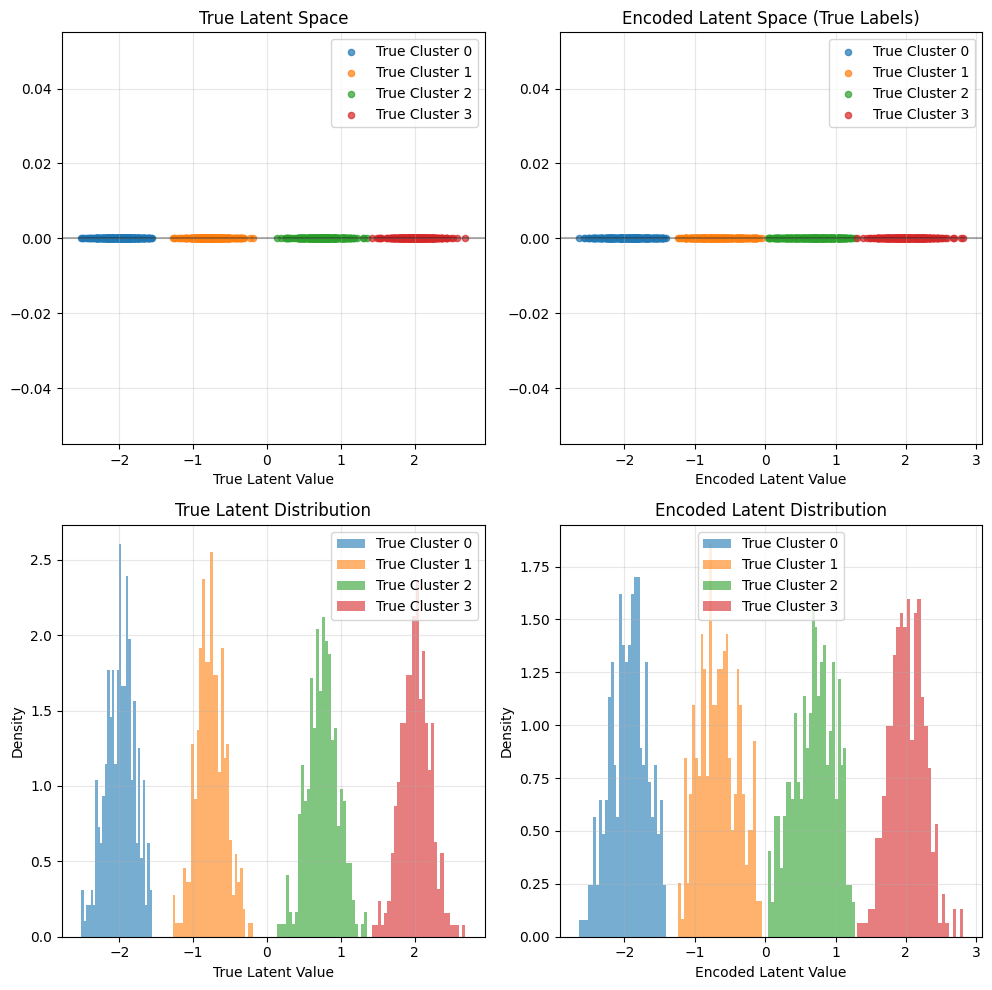

In [8]:
# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: True vs Predicted latent space
plt.subplot(2, 3, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Encoded latent space colored by true labels
plt.subplot(2, 3, 2)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Encoded Latent Value')
plt.ylabel('')
plt.title('Encoded Latent Space (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)


# Plot 4: Histogram comparison - True latent
plt.subplot(2, 3, 4)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('True Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Histogram comparison - Encoded latent
plt.subplot(2, 3, 5)
for i in range(n_clusters):
    mask = y == i
    plt.hist(enc_mu[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('Encoded Latent Value')
plt.ylabel('Density')
plt.title('Encoded Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()